# Domain Specific ASR: Wall Street Journal (WSJ) use case

In this notebook we exemplify the end-to-end workflow of ASR domain adaptation using the `Domain Specific NeMo ASR application`. We start with an acoustic model pre-trained on open-source English datasets **[LibriSpeech](http://www.openslr.org/12)** and [English - Mozilla Common Voice](https://voice.mozilla.org/en/datasets) and fine-tune with **Wall Street Journal (WSJ)** news dataset. Next, to further improve domain performance, we train language model based on prefix beam search [KenLM]( https://github.com/kpu/kenlm) which imposes a language model constraint on the new predicted character based on previous (most probable) prefixes. The language Model we train is the [Baidu’s CTC decoder with N-Gram LM implementation](https://github.com/PaddlePaddle/DeepSpeech).

Through this example case, we show we can easily do transfer learning or domain adaptation from [relatively old] fiction books (LibriSpeech) to [relatively modern] business news (WSJ).

The steps followed in this notebook are:
1. Preparations: Download Pre-trained model, Create Project and Datasets preparation
2. Train (fine-tune) Acoustic Model
3. Train Language Model
4. Inference with Pre-trained and Fine-tuned models
5. Compare models
6. Export model for deployment

In [1]:
# set directory to save results to
import os
if os.environ.get("DATA_DIR") == None:
    os.environ["DATA_DIR"] = "/data"
data_dir = os.environ.get("DATA_DIR")
print(data_dir)

# required imports
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from easydict import EasyDict as edict

from tools.System.config import cfg
from tools.System.reader import Reader
from tools.System.nemo_fns import get_onnx_cmd, get_onnx_trt_cmd
from tools.filetools import file_exists
from tools.misc import create_lm_dataset, parse_manifest_wer, barplot_manifest, get_transcript, get_gtruth

/data


# 1. Preparations

## 1.1 Download Pre-trained model from NGC
**The pre-trained model is already provided inside the container for you and loaded into the project's manifest by default.**

Download pre-trained model from NGC. There exists multiple pre-trained models in [NGC](https://ngc.nvidia.com/catalog/models?orderBy=modifiedDESC&query=nemo&quickFilter=models&filters=), select the pre-trained Jasper or QuartzNet model of your preference. 

In this example we use:
### LibriSpeech and Common Voice QuartzNet 15x5 for NeMo
https://ngc.nvidia.com/catalog/models/nvidia:quartznet15x5

QuarzNet is a Jasper-like network which uses separable convolutions and larger filter sizes. It has comparable accuracy to Jasper while having much fewer parameters. This particular model has 15 blocks each repeated 5 times.

QuartzNet15x5 Encoder and Decoder neural module's checkpoints available here are trained using Neural Modules (NeMo) toolkit. NVIDIA’s Apex/Amp O1 optimization level was used for training on 8xV100 GPUs. These modules were trained using LibriSpeech (+-10% speed perturbation) and Mozilla's EN Common Voice "validated" set. 

Steps:
- Download pre-trained model from NGC
- unzip model inside the example_data directory

Other pre-trained models:
### Multidataset QuartzNet 15x5 for NeMo
https://ngc.nvidia.com/catalog/models/nvidia:multidataset_quartznet15x5

## 1.2 Create a new project

We create a project that will keep track of the datasets, configurations and models created across the acoustic model and language model workflows.
Everything related to a project is saved in disc in a manifest that can be access through its `project_id`.

At the start of the project, the manifest is pre-populated with the baseline acoustic model - a model pretrained on LibriSpeech and using greedy decoder.

In [2]:
project_id = 'WSJ-test'

project = Reader.new(project_id)
#project.manifest

Training config file: /data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml
Inference config file: /data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml
Manifest is saved /data/results/manifests/WSJ-test_manifest.json 



## 1.3 Datasets

### 1.3.1 Acoustic Dataset

In this example use-case, we fine-tune the pre-trained acoustic and language models with Wall Street Journal news datasets. 

This dataset is part of the Linguistic Data Consortium and can be found here:
- CSR-I (WSJ0) Complete: https://catalog.ldc.upenn.edu/LDC93S6A
- CSR-II (WSJ1) Complete: https://catalog.ldc.upenn.edu/LDC94S13A

Note: To download this dataset a license is required please refer to [LDC to learn more](https://www.ldc.upenn.edu/language-resources/data/obtaining). 

### Create NeMo ready - Acoustic Model Dataset
NeMo requires datasets to be in the format of:
- `wav` audio clips with sampling rate (16000) and max clip duration (16.5) specified by the [configuration file](/tools/NeMo/example_configs/quartznet15x5.yaml).
- The dataset format as a `json` file where each entry has the keys: `audio_filepath`, `duration` and `text`.

You can see the script used to create NeMo datasets from common_voice datasets in `tools/NeMo/create_common_voice_dataset.py`. This script can help you correctly format your audio clips and json training dataset. As well, you must normalize the text, i.e. lowercase text, remove punctuations and change digits to text representation. We provide utility functions inside the tools folder, e.g. `tools/transcript_tools.py`, that can help you with dataset preparation.

After you create your dataset, make sure that the pre-processed dataset has the correct paths to the audio files. You can use the following commands to check and fix the paths.

**Best practice: To obtain a better performing model you can use speed-perturbation (+-10%) to augment your dataset. To do this you can use tools like sox.**

In [3]:
# check audio_filepath exists
!head -n1 /data/datasets/wsj-train-si284-speed-0.9-1.1.json
#!head -n1 /data/datasets/wsj-eval-92.json
#!head -n1 /data/datasets/wsj-dev-93.json

{"audio_filepath": "/data/wsj/csr_2_comp/13-1.1/wsj1/si_tr_s/460/460c0201.wav", "duration": 7.178375, "text": "earlier this week defense secretary caspar weinberger told reporters at a breakfast meeting that the b one's problems weren't serious"}


In [4]:
assert file_exists("/data/wsj/csr_2_comp/13-1.1/wsj1/si_tr_s/460/460c0201.wav"), "file does not exist."

In [5]:
# If incorrect path replace this path with the correct path inside the container:
#!sed -i 's,/data/example_data,,g' /data/datasets/wsj-train-si284-speed-0.9-1.1.json
#!sed -i 's,/data/example_data,,g' /data/datasets/wsj-eval-92.json
#!sed -i 's,/data/example_data,,g' /data/datasets/wsj-dev-93.json

In [6]:
# confirm change
#!head -n1 /data/datasets/wsj-train-si284-speed-0.9-1.1.json
#!head -n1 /data/datasets/wsj-eval-92.json
#!head -n1 /data/datasets/wsj-dev-93.json

### 1.3.2 Language Model dataset
You can create a languague model dataset from the transcripts (labels) of your acoustic training dataset. You can use the function below.

In [7]:
#data_lm = os.path.join("datasets", "wsj-train-si284.json") # input acoustic dataset
#train_lm = os.path.join("datasets", "wsj-lm-train-si284.txt") # name of output lm dataset
#create_lm_dataset(data_lm, train_lm)

# 2. Train Acoustic Model - Transfer Learning with NeMo
In the next steps we finetune a baseline model with our own data.

The steps are: 
1. Add pre-processed dataset to project
2. Adjust training parameters
3. Generate training command
4. Perform Training 

## 2.1. Add Training Datasets to the Project 
To train an acoustic model you require a pre-processed `json` training dataset.
NeMo expects the dataset as a `json` file where each entry has the keys: `audio_filepath`, `duration` and `text`.

**Here is where you can add your own domain specific acoustic dataset.**

In [8]:
# train dataset
train_json = "/data/datasets/wsj-train-si284-speed-0.9-1.1.json"
assert file_exists(train_json), "Train dataset file does NOT exist."

project.add_dataset(train_json, "WSJ-wsj-train-speed", dataset_type="am-train")
project.manifest.am

{'train_dataset_name': 'WSJ-wsj-train-speed',
 'train_dataset': '/data/datasets/wsj-train-si284-speed-0.9-1.1.json',
 'finetuned_model_path': None,
 'train_cmd': None,
 'infer_cmd': None,
 'train_params': {'num_gpus': 1,
  'batch_size': 16,
  'num_epochs': 1,
  'lr': None,
  'warmup_steps': None,
  'weight_decay': None,
  'model_config': '/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml',
  'optimizer': 'novograd',
  'amp_opt_level': 'O1',
  'beta1': None,
  'beta2': None,
  'finetune': True,
  'load_encoder': '/tmp/nemo_asr_app/models/quartznet15x5/JasperEncoder-STEP-247400.pt',
  'load_decoder': '/tmp/nemo_asr_app/models/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt',
  'work_dir': '/data/results/models/acoustic_models/WSJ-test'}}

## 2.2 Modify acoustic model training parameters
The default training parameters are specified in the project manifest, training script and the configuration file  `[DATA_DIR]/results/config_files/]PROJCECT]_acoustic_quartznet15x5.yaml`. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.am.train_params`, to see other parameters look at the NeMo training script at `/tools/NeMo/jasper_train.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).
- To enable finetuning you must set the parameter `finetuning` to "True" and set the path to the `pre-trained encoder and decoder` to the parameters `load_encoder` and `load_decoder` respectively. Note, the finetuning and pre-trained encoder and decoders are already added at the start of the project.

In [9]:
# set training parameters 
project.set_am_batch_size(32)
project.set_am_num_gpus(4)
project.set_am_learning_rate(0.0001)
project.manifest.am.train_params.warmup_steps = 0 
#project.manifest.am.train_params.weight_decay = 0.0001
project.manifest.am.train_params.amp_opt_level = 'O1'

# If your dataset has 200+ Hrs of audio you can fine-tune for less epochs, e.g. 100.
#project.set_am_num_epochs(100)
project.set_am_num_epochs(1)

# novograd
#project.manifest.am.train_params.beta1 = 0.95
#project.manifest.am.train_params.beta2 = 0.25 

# To modify the path to config file and the pretrained model
#project.load_am_config_file(config_file='')
#project.set_am_pretrained_model(model='')

project.save_manifest()
project.manifest.am

{'train_dataset_name': 'WSJ-wsj-train-speed',
 'train_dataset': '/data/datasets/wsj-train-si284-speed-0.9-1.1.json',
 'finetuned_model_path': None,
 'train_cmd': None,
 'infer_cmd': None,
 'train_params': {'num_gpus': 4,
  'batch_size': 32,
  'num_epochs': 1,
  'lr': 0.0001,
  'warmup_steps': 0,
  'weight_decay': None,
  'model_config': '/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml',
  'optimizer': 'novograd',
  'amp_opt_level': 'O1',
  'beta1': None,
  'beta2': None,
  'finetune': True,
  'load_encoder': '/tmp/nemo_asr_app/models/quartznet15x5/JasperEncoder-STEP-247400.pt',
  'load_decoder': '/tmp/nemo_asr_app/models/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt',
  'work_dir': '/data/results/models/acoustic_models/WSJ-test'}}

## 2.3 Generate Training Command
Next we generate the acoustic model training command, where we use the settings specified in the manifest to create the appropriate command.

In [10]:
am_training_cmd = project.get_am_train_cmd()
print("! "+ am_training_cmd)

! python -m torch.distributed.launch --nproc_per_node=4 /tmp/nemo_asr_app/tools/NeMo/jasper_train.py --batch_size=32 --num_epochs=1 --lr=0.0001 --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --optimizer=novograd --amp_opt_level=O1 --finetune --load_encoder=/tmp/nemo_asr_app/models/quartznet15x5/JasperEncoder-STEP-247400.pt --load_decoder=/tmp/nemo_asr_app/models/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt --work_dir=/data/results/models/acoustic_models/WSJ-test --exp_name=WSJ-test_finetuning --train_dataset=/data/datasets/wsj-train-si284-speed-0.9-1.1.json


## 2.4 Finetune Pretrained Jasper Model
Now that we have the training command that reflects our project settings, we can perform acoustic model training. Note, acoustic model training can take a long time so it is better to run training directly from the terminal of the container, using the command generated.

Note, if you completed the training before, you'll have checkpoints saved in the working directory.  We'll need to remove these to restart training. 

In [11]:
# clean log directory to re-run the training command
# project.clean_am_workdir()

# 3. Train a Language Model

Up to now, the transcript the ASR system generates is through an “end-to-end” [CTC-based network]( https://www.cs.toronto.edu/~graves/icml_2006.pdf) which matches audio and text without additional alignment information. However, ambiguities in the transcription, for example when collapsing repeated characters and removing blanks, can exist as the CTC-based network has little prior linguistic knowledge. This is where a language model comes in, as it can help solve those decoding ambiguities.

Specifically, the decoder output or transcript, when introducing a language model, is dependent on both the CTC network (softmax) output and the language model prediction. The language model we use is based on prefix beam search [KenLM]( https://github.com/kpu/kenlm) which imposes a language model constraint on the new predicted character based on previous (most probable) prefixes. To learn more see [First-Pass Large Vocabulary Continuous Speech Recognition using Bi-Directional Recurrent DNNs](https://arxiv.org/pdf/1408.2873.pdf).

In this notebook we train the [Baidu’s CTC decoder with N-Gram LM implementation](https://github.com/PaddlePaddle/DeepSpeech).

The steps are: 1. Add pre-processed dataset to project, 2. Edit training parameters 3. Generate training command and perform training.

## 3.1 Add LM Dataset to project

To train a language model you require the pre-processed training text as a single column (per sentence) saved as a .txt file. **Here is where you can add your own domain specific dataset.**

In [12]:
train_lm =  "/data/datasets/wsj-lm-data-small.txt"
assert file_exists(train_lm), "Train dataset file does not exist."

project.add_dataset(train_lm, "LM-train", dataset_type="lm-train")
project.manifest.lm

{'train_dataset_name': 'LM-train',
 'train_dataset': '/data/datasets/wsj-lm-data-small.txt',
 'ngram': 6,
 'finetuned_model': '/data/results/models/language_models/WSJ-test_lm.binary',
 'train_cmd': None,
 'infer_cmd': None}

## 3.2 Edit Training Parameters
We first edit language model training parameters. Here the only parameter to edit is the length of the sequence of words `(N)` used by the N-gram model.

In [13]:
# edit parameters
project.set_n_gram(6) # number of words for N-Gram
project.manifest.lm

{'train_dataset_name': 'LM-train',
 'train_dataset': '/data/datasets/wsj-lm-data-small.txt',
 'ngram': 6,
 'finetuned_model': '/data/results/models/language_models/WSJ-test_lm.binary',
 'train_cmd': None,
 'infer_cmd': None}

## 3.3 Training Language Model
The following function will generate the language model training command for our dataset. You can run this command directly in this notebook or in the container terminal.

In [14]:
lm_train_cmd = project.get_lm_train_cmd()
print ("! " + lm_train_cmd)

! python /tmp/nemo_asr_app/tools/NeMo/build_lm.py /data/datasets/wsj-lm-data-small.txt --n=6 --project_id=WSJ-test


In [15]:
# clean log directory to re-run the training 
#project.clean_lm_logdir()

# 4. Inference with Pre-trained and Fine-tuned Models
Next, we perform inference with both the pre-trained and fine-tuned models.

The steps are: 
1. Add pre-processed evaluation datasets to project
2. Inference using: Pre-trained model (Greedy Decoder)
3. Inference using: Finetuned acoustic model (Greedy Decoder)
4. Inference using: Finetuned acoustic model with added Language model

At each inference case, we follow 3 steps: 1) Adjust inference parameters 2) Generate inference command 3) Perform inference

## 4.1. Add Inference Evaluation Datasets to the Project 
To perform inference you require a preprocessed `json` dataset, with the columns: `audio_filepath`, `duration` and `text`.

In [16]:
# add inference dataset
eval_json="/data/datasets/wsj-eval-92.json"
#eval_json="data/datasets/wsj-dev-93.json"
assert file_exists(eval_json), "Evaluation dataset file does not exist."

project.add_dataset(eval_json, "wsj-eval", dataset_type="eval")

# Becuase we already added the evaluation dataset to project when doing the AM workflow we don't need to do it again
print(project.manifest.eval_dataset_names)
print(project.manifest.eval_datasets)

['wsj-eval']
['/data/datasets/wsj-eval-92.json']


## 4.2 Inference with Pre-trained model

### 4.2.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_infer.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

- When `lm_path` is set to "None", the system will use a `greedy decoder`, and thus the language model parametrs `beam_width`, `alpha`, `beta` will not be used.

In [17]:
# pre-trained model already loaded from the models folder
project.manifest.inference_params.batch_size = 32
project.manifest.inference_params.amp_opt_level = 'O1'

project.save_manifest()
project.manifest.inference_params

{'load_dir': '/tmp/nemo_asr_app/models/quartznet15x5',
 'model_config': '/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O1',
 'save_results': '/data/results/inferences/WSJ-test',
 'lm_path': None,
 'beam_width': None,
 'alpha': None,
 'beta': None}

### 4.2.2 Generate Inference Command: Pre-trained Model
We generate the inference command using the manifest configurations and define a name to identify the model we use.

In [18]:
# Model Id - We use this to identify the results of this model
model_id = "Pretrained-greedy_decoder"

# Inference with Pre-trained model
am_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ am_infer_cmd)

! python /tmp/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/tmp/nemo_asr_app/models/quartznet15x5 --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/data/results/inferences/WSJ-test --eval_datasets=/data/datasets/wsj-eval-92.json --model_id=Pretrained-greedy_decoder


### 4.2.3 Run Inference with Pre-trained Model
To run inference, copy the command generated above and paste below.

In [19]:
! python /tmp/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/tmp/nemo_asr_app/models/quartznet15x5 --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/data/results/inferences/WSJ-test --eval_datasets=/data/datasets/wsj-eval-92.json --model_id=Pretrained-greedy_decoder

/opt/conda/lib/python3.6/site-packages/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')
[NeMo I 2020-04-09 22:22:35 collections:138] Dataset loaded with 333 files totalling 0.71 hours
[NeMo I 2020-04-09 22:22:35 collections:139] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-04-09 22:22:35 jasper_eval:109] Evaluating 333 examples
[NeMo I 2020-04-09 22:22:35 features:144] PADDING: 16
[NeMo I 2020-04-09 22:22:35 features:152] STFT using conv
[NeMo I 2020-04-09 22:22:37 jasper_eval:122] ================================
[NeMo I 2020-04-09 22:22:37 jasper_eval:124] Number of parameters in encoder: 18894656
[NeMo I 2020-04-09 22:22:37 jasper_eval:126] Number of parameters in decoder: 29725
[NeMo I 2020-04-09 22:22:37 jasper_eval:128] Total number of parameters: 18924381
[NeMo I 2020-04-09 22:22:37 jasper_eval:130] ======================

## 4.3 Inference with Finetuned model (Greedy Decoder)

### 4.3.1 Modify inference parameters
To use the fintuned acoustic model you **must** modify:
- The `project.manifest.inference_params.load_dir` to use the fine-tuned model not the default pretrained model.
    - The path to the finetuned model can be found at `project.manifest.am.finetuned_model_path`

In [20]:
# Inference with Fintuned model
# We provide the finetuned model inside the models folder
project.manifest.inference_params.load_dir = os.path.join(os.environ['APP_DIR'], 'models', 'wsj_finetuned') 
# But if you fintuned the model, the path is available in project.manifest.am.finetuned_model_path
#project.manifest.inference_params.load_dir = project.manifest.am.finetuned_model_path

project.manifest.inference_params.amp_opt_level = 'O1'

project.save_manifest()
project.manifest.inference_params

{'load_dir': '/tmp/nemo_asr_app/models/wsj_finetuned',
 'model_config': '/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O1',
 'save_results': '/data/results/inferences/WSJ-test',
 'lm_path': None,
 'beam_width': None,
 'alpha': None,
 'beta': None}

### 4.3.2 Generate Inference Command
We generate the inference command using the manifest configurations.

In [21]:
# Model Id - We use this to identify the results of this model
model_id = "Finetuned_WSJ-greedy_decoder"

# Inference with Fine-tuned model
am_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ am_infer_cmd)

! python /tmp/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/tmp/nemo_asr_app/models/wsj_finetuned --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/data/results/inferences/WSJ-test --eval_datasets=/data/datasets/wsj-eval-92.json --model_id=Finetuned_WSJ-greedy_decoder


### 4.3.3 Run Inference with Fine-tuned Model
To run inference, copy the command generated above and paste below.

In [22]:
! python /tmp/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/tmp/nemo_asr_app/models/wsj_finetuned --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/data/results/inferences/WSJ-test --eval_datasets=/data/datasets/wsj-eval-92.json --model_id=Finetuned_WSJ-greedy_decoder

/opt/conda/lib/python3.6/site-packages/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')
[NeMo I 2020-04-09 22:22:46 collections:138] Dataset loaded with 333 files totalling 0.71 hours
[NeMo I 2020-04-09 22:22:46 collections:139] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-04-09 22:22:46 jasper_eval:109] Evaluating 333 examples
[NeMo I 2020-04-09 22:22:46 features:144] PADDING: 16
[NeMo I 2020-04-09 22:22:46 features:152] STFT using conv
[NeMo I 2020-04-09 22:22:49 jasper_eval:122] ================================
[NeMo I 2020-04-09 22:22:49 jasper_eval:124] Number of parameters in encoder: 18894656
[NeMo I 2020-04-09 22:22:49 jasper_eval:126] Number of parameters in decoder: 29725
[NeMo I 2020-04-09 22:22:49 jasper_eval:128] Total number of parameters: 18924381
[NeMo I 2020-04-09 22:22:49 jasper_eval:130] ======================

## 4.4 Inference with Fine-tuned model and Language Model

### 4.4.1 Modify inference parameters

In this section we **need to** set the LM parameters to enable inference with the beam-search decoder, specifically the trained LM model.

The parameters to change are:
- `lm_path`: Pointing to the `binary` file of the LM model you wish to use. The function `project.get_path_to_lm()` will return the path project's language model.
- `beam_width`: determining how many prefixes (beams) will be selected at each timestep.
- `alpha`: the weight of the language model.
- `beta`: compensation term or word insertion weight. Required to control length of candidates (balance number of words).

In [23]:
# Fintuned Acoustic model
project.manifest.inference_params.load_dir = os.path.join(os.environ['APP_DIR'], 'models', 'wsj_finetuned') 

# Inference with language model
# We provide the language model inside the models folder
project.manifest.inference_params.lm_path = os.path.join(os.environ['APP_DIR'], 'models', 'lm', 'WSJ_lm.binary') 

# But if you trained the language model, the path is available at project.get_path_to_lm()
#project.manifest.inference_params.lm_path =  project.get_path_to_lm()

# beam parameters
project.manifest.inference_params.beam_width = 200
project.manifest.inference_params.alpha = 3.0
project.manifest.inference_params.beta = 0.1

# other parameters
project.manifest.inference_params.batch_size = 32
project.manifest.inference_params.amp_opt_level = 'O1'

project.save_manifest()
project.manifest.inference_params

{'load_dir': '/tmp/nemo_asr_app/models/wsj_finetuned',
 'model_config': '/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O1',
 'save_results': '/data/results/inferences/WSJ-test',
 'lm_path': '/tmp/nemo_asr_app/models/lm/WSJ_lm.binary',
 'beam_width': 200,
 'alpha': 3.0,
 'beta': 0.1}

### 4.4.2 Generate Inference Command
We generate the inference command using the manifest configurations.

In [24]:
# Model Id - We use this to identify the results of this model
model_id = "Finetuned-WSJ-LM-WSJ"

# Inference with Fine-tuned acoustic model and language model
lm_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ lm_infer_cmd)

! python /tmp/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/tmp/nemo_asr_app/models/wsj_finetuned --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/data/results/inferences/WSJ-test --lm_path=/tmp/nemo_asr_app/models/lm/WSJ_lm.binary --beam_width=200 --alpha=3.0 --beta=0.1 --eval_datasets=/data/datasets/wsj-eval-92.json --model_id=Finetuned-WSJ-LM-WSJ


### 4.4.3 Run Inference with Finetuned Model with Language Model
To run inference, copy the command generated above and paste below.

In [25]:
! python /tmp/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/tmp/nemo_asr_app/models/wsj_finetuned --model_config=/data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/data/results/inferences/WSJ-test --lm_path=/tmp/nemo_asr_app/models/lm/WSJ_lm.binary --beam_width=200 --alpha=3.0 --beta=0.1 --eval_datasets=/data/datasets/wsj-eval-92.json --model_id=Finetuned-WSJ-LM-WSJ

/opt/conda/lib/python3.6/site-packages/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')
[NeMo I 2020-04-09 22:22:58 collections:138] Dataset loaded with 333 files totalling 0.71 hours
[NeMo I 2020-04-09 22:22:58 collections:139] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-04-09 22:22:58 jasper_eval:109] Evaluating 333 examples
[NeMo I 2020-04-09 22:22:58 features:144] PADDING: 16
[NeMo I 2020-04-09 22:22:58 features:152] STFT using conv
[NeMo I 2020-04-09 22:23:00 jasper_eval:122] ================================
[NeMo I 2020-04-09 22:23:00 jasper_eval:124] Number of parameters in encoder: 18894656
[NeMo I 2020-04-09 22:23:00 jasper_eval:126] Number of parameters in decoder: 29725
[NeMo I 2020-04-09 22:23:00 jasper_eval:128] Total number of parameters: 18924381
[NeMo I 2020-04-09 22:23:00 jasper_eval:130] ======================

# 5. Models Comparison
Next, we compare the Word Error Rates for both the fine-tuned model and pre-trained model.

## 5.1 Add Inference results to manifest
We first add the results from our inference runs to the project's manifest.

In [26]:
project.add_inference_results()
inferences_all = list(project.manifest.inference.keys())
inferences_all.sort()
print(inferences_all)

Added results for model Pretrained-greedy_decoder - /data/datasets/wsj-eval-92.json.
Added results for model Finetuned_WSJ-greedy_decoder - /data/datasets/wsj-eval-92.json.
Added results for model Finetuned-WSJ-LM-WSJ - /data/datasets/wsj-eval-92.json.
['/data/datasets/wsj-eval-92.json']


## 5.2 Word Error Rate Comparison
We plot WER performance of eval dataset and we also select the performance metric we wish to sort by.

Note, if `lm_wer` is present we chose that value over the `wer` value.

In [27]:
sel_inference = project.manifest.inference[inferences_all[0]]
sel_inference

{'Pretrained-greedy_decoder': {'wer': 0.10012404749246855,
  'path': '/data/results/inferences/WSJ-test/results-am_grid__wsj-eval-92__Pretrained-greedy_decoder.json',
  'lm_wer': None},
 'Finetuned_WSJ-greedy_decoder': {'wer': 0.045188729399255716,
  'path': '/data/results/inferences/WSJ-test/results-am_grid__wsj-eval-92__Finetuned_WSJ-greedy_decoder.json',
  'lm_wer': None},
 'Finetuned-WSJ-LM-WSJ': {'wer': 0.045188729399255716,
  'path': '/data/results/inferences/WSJ-test/results-lm_grid__wsj-eval-92__Finetuned-WSJ-LM-WSJ.json',
  'lm_wer': 0.021974127237285132}}

In [28]:
sort_metric = 'percentWER'
# Note if you wish to plot (and parse) only a specific set of models you can use the argument 'keep' and 
# list the model_id(s) you wish to keep.
df = parse_manifest_wer(sel_inference, sort_metric=sort_metric)
                           
print(inferences_all[0])
df

/data/datasets/wsj-eval-92.json


,inference_types,lm_wer,wer,percentWER
2,Finetuned-WSJ-LM-WSJ,0.021974,0.045189,2.197413
1,Finetuned_WSJ-greedy_decoder,NaN,0.045189,4.518873
0,Pretrained-greedy_decoder,NaN,0.100124,10.012405


We use the dataframe created by the `parse_manifest_wer` function to plot the performance of the different models.
We use the function `barplot_manifest` that has the arguments `([dataframe],[metric to plot],[title],[xlabel],[ylabel])`.

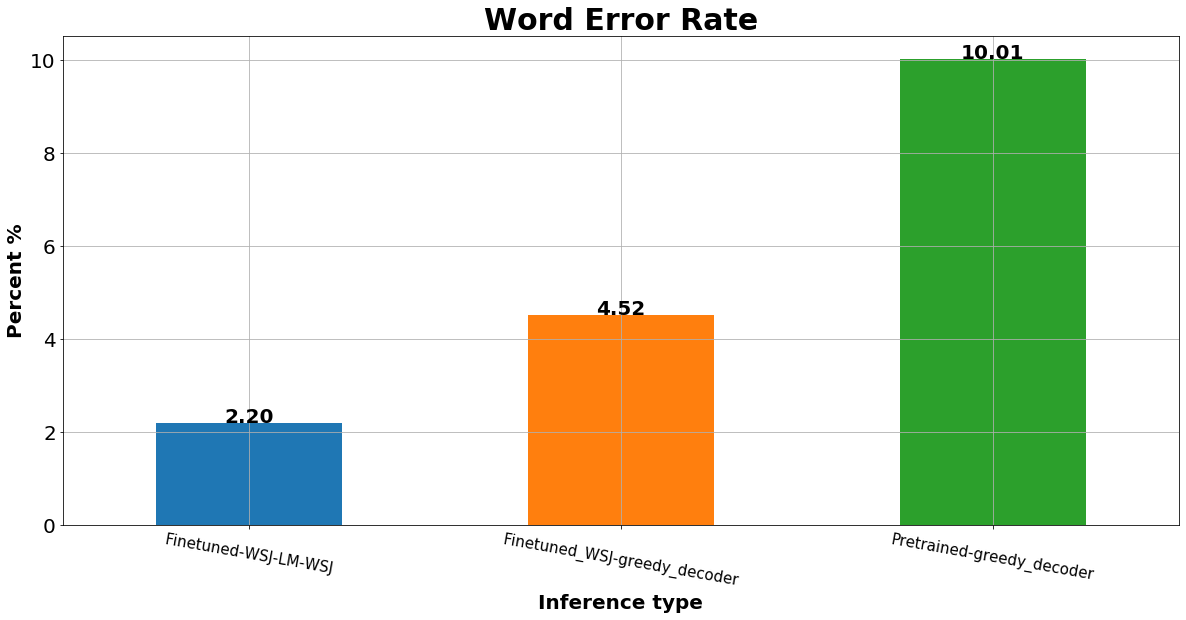

In [29]:
%matplotlib inline
wer = barplot_manifest(df,'percentWER',"Word Error Rate", "Inference type","Percent %")

## 5.3 Performance improvement

In [30]:
df.set_index('inference_types', inplace=True)

In [31]:
org = df.loc['Pretrained-greedy_decoder','wer'] # pre-trained model
new = df.loc['Finetuned-WSJ-LM-WSJ','lm_wer'] # fine-tuned am and lm model

In [32]:
per_decrease = 100*((org-new)/org)
print("Decreased WER by {0:.2f}%".format(per_decrease))

Decreased WER by 78.05%


# 6. Model Deployment
Now that you have created SOTA performance for your domain, you are ready to export your model to be deployed. 

The process to follow is:
1. [NeMo](https://github.com/NVIDIA/NeMo) checkpoint -> ONNX
2. ONNX -> [NVIDIA TensorRT](https://developer.nvidia.com/tensorrt)

After this process you will be ready to deploy your optimized model with [NVIDIA Jarvis]( https://developer.nvidia.com/nvidia-jarvis) or [TensorRT Inference Server](https://devblogs.nvidia.com/nvidia-serves-deep-learning-inference/).

Definitions:
- **ONNX** is a standard for representing deep learning models enabling them to be transferred between frameworks.
- **TensorRT** enables the network to be compressed, optimized and deployed as a runtime without the overhead of a framework.
- **NVIDIA Jarvis** is an SDK for building and deploying AI applications that fuse vision, speech and other sensors.
- **NVIDIA TensortRT Inference Server** is an inference microservice for data center production that maximizes GPU utilization and seamlessly integrates into DevOps deployments with Docker and Kubernetes integration.

## 6.1 NeMo model checkpoints to ONNX
This process will convert the `.pt` model checkpoints into `onnx` format. After you run this process you should have two .onnx files - one for the encoder and one for the decoder.

In [33]:
pretrained = False
if pretrained:
    # pre-trained model
    config = project.manifest.am.train_params.model_config
    encoder = project.manifest.am.train_params.load_encoder
    decoder = project.manifest.am.train_params.load_decoder
    onnx_encoder = os.path.join(cfg.MODEL.ONNX_MODELS,"pre-trained_encoder.onnx")
    onnx_decoder = os.path.join(cfg.MODEL.ONNX_MODELS,"pre-trained_decoder.onnx")
    print("Exporting pre-trained model")
    print("Encoder:", encoder)
    print("Decoder", decoder)
else:
    # fine-tuned model
    config = project.manifest.am.train_params.model_config
    # if you wish to use the finetuned model you can use the encoder and decoder in: 
    # project.manifest.am.finetuned_model_path
    encoder = os.path.join(cfg.NEMO.WSJ_FINETUNED,"JasperEncoder-STEP-174000.pt")
    decoder = os.path.join(cfg.NEMO.WSJ_FINETUNED, "JasperDecoderForCTC-STEP-174000.pt")
    onnx_encoder = os.path.join(cfg.MODEL.ONNX_MODELS,"finetuned_encoder.onnx")
    onnx_decoder = os.path.join(cfg.MODEL.ONNX_MODELS,"finetuned_decoder.onnx")
    print("Exporting fine-tuned model")
    print("Encoder:", encoder)
    print("Decoder", decoder)

Exporting fine-tuned model
Encoder: /tmp/nemo_asr_app/models/wsj_finetuned/JasperEncoder-STEP-174000.pt
Decoder /tmp/nemo_asr_app/models/wsj_finetuned/JasperDecoderForCTC-STEP-174000.pt


In [34]:
onnx_cmd = get_onnx_cmd(config, encoder, decoder, onnx_encoder, onnx_decoder)
print("! " + onnx_cmd)

! python /workspace/nemo/scripts/export_jasper_to_onnx.py --config /data/results/config_files/WSJ-test_acoustic_quartznet15x5.yaml --nn_encoder /tmp/nemo_asr_app/models/wsj_finetuned/JasperEncoder-STEP-174000.pt --nn_decoder /tmp/nemo_asr_app/models/wsj_finetuned/JasperDecoderForCTC-STEP-174000.pt --onnx_encoder /data/results/models/ONNX/finetuned_encoder.onnx --onnx_decoder /data/results/models/ONNX/finetuned_decoder.onnx


## 6.2 ONNX to TRT
Next, we convert the ONNX model files to TensorRT to enable inference optimization that delivers low latency and high-throughput. In this process you are generating an engine that is optimized for a target platform.

Note: You must convert both the Encoder and Decoder files. 
Learn more at: https://developer.nvidia.com/tensorrt

Since the optimization is platform specific, if you wish to modify the model export parameters, look at the script: `/tmp/NeMo/scripts/export_jasper_onnx_to_trt.py`

### 6.2.1 Convert Decoder
Run the following command to export the ONNX Decoder model to TensorRT.

In [35]:
# decoder
onnx_path = onnx_decoder
if pretrained:
    trt_plan = os.path.join(cfg.MODEL.TRT_MODELS,"pre-trained_decoder_trt_plan.engine")
else:
    # fine-tuned model
    trt_plan = os.path.join(cfg.MODEL.TRT_MODELS,"finetuned_decoder_trt_plan.engine")
trt_cmd = get_onnx_trt_cmd(onnx_path, trt_plan)
print("! " + trt_cmd)

! python /workspace/nemo/scripts/export_jasper_onnx_to_trt.py /data/results/models/ONNX/finetuned_decoder.onnx /data/results/models/TRT/finetuned_decoder_trt_plan.engine


### 6.2.1 Convert Encoder
Run the following command to export the ONNX Encoder model to TensorRT.

In [36]:
# encoder
onnx_path = onnx_encoder
if pretrained:
    trt_plan = os.path.join(cfg.MODEL.TRT_MODELS,"pre-trained_encoder_trt_plan.engine")
else:
    # fine-tuned model
    trt_plan = os.path.join(cfg.MODEL.TRT_MODELS,"finetuned_encoder_trt_plan.engine")
trt_cmd = get_onnx_trt_cmd(onnx_path, trt_plan)
print("! " + trt_cmd)

! python /workspace/nemo/scripts/export_jasper_onnx_to_trt.py /data/results/models/ONNX/finetuned_encoder.onnx /data/results/models/TRT/finetuned_encoder_trt_plan.engine
